In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


from textblob import TextBlob 
from wordcloud import WordCloud 

import plotly.graph_objects as go

import json
import re 
import tweepy 
from tweepy import OAuthHandler 
from textblob import TextBlob 

import warnings
warnings.filterwarnings('ignore')

In [2]:
with open('/Users/davidtorres/.secret/config_Mod_5.json') as file:
    json_data = json.load(file)

In [3]:
authenticate = tweepy.OAuthHandler(json_data['consumer_key'],json_data['consumer_secret_key'])
authenticate.set_access_token(json_data['access_token'], json_data['access_token_secret'])

In [4]:
api = tweepy.API(authenticate, wait_on_rate_limit= True)
#api = tweepy.API(authenticate, wait_on_rate_limit= True)
#api = tweepy.API(authenticate, wait_on_rate_limit= True)
posts = api.user_timeline(screen_name='@pfizer', count=5, lang='en', tweet_mode='extended')
#tweets = api.user_timeline(screen_name='whoever', count=5, tweet_mode='extended')


In [5]:
def get_tweets(posts):
    tweet_list = []
    for twt in posts:
        tweet_list.append(twt._json)
    tweet_data = pd.DataFrame.from_records(tweet_list)#tweet_df = tweet_data[['created_at','full_text']]
    tweet_df = tweet_data[['created_at','full_text']]
    tweet_df['Date'] = pd.to_datetime(tweet_df['created_at'])
    tweet_df['Date'] = pd.to_datetime(tweet_df['Date'], format='%Y:%m:%d').dt.date
    tweet_df.set_index(["Date"], inplace = True) 
    tweet_df.drop('created_at',axis=1,inplace=True)
    return tweet_df

In [6]:
tweets_df = get_tweets(posts)
tweets_df

,full_text
Date,
2021-04-12,The next big thing in the fight against the pa...
2021-04-09,https://t.co/zwPx9u9ear
2021-04-09,Learn more about our study and this filing: ht...
2021-04-09,"Pending regulatory decision, our hope is to ma..."
2021-04-09,We plan to request similar rulings by other re...


In [7]:
#clean the text
def cleanTxt(text):
    text = re.sub(r'@[A-Za-z0-9]+','',text) #r-tells python that expression is a raw tring, once we find substitute fo empty string
  #get rid of any hashtag or number sign
    text = re.sub(r'#', '', text)
    text = re.sub(r'RT[\s]+','', text)  #retweets followed by 1 or more white spaces
    #remove the hyper link
    text = re.sub(r'https?:\/\/\S+','', text)      #may have 0 or 1 s character
    
    return text

In [8]:
#cleaning hte text
tweets_df['full_text'] = tweets_df['full_text'].apply(cleanTxt)

In [9]:
pd.set_option('display.max_rows', None)
tweets_df

,full_text
Date,
2021-04-12,The next big thing in the fight against the pa...
2021-04-09,
2021-04-09,Learn more about our study and this filing:
2021-04-09,"Pending regulatory decision, our hope is to ma..."
2021-04-09,We plan to request similar rulings by other re...


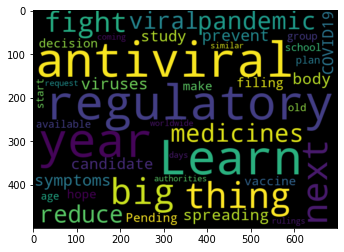

In [10]:
allWords = ' '.join([twts for twts in tweets_df['full_text']])
wordCloud = WordCloud(width=700, height=500, random_state=21,max_font_size=110).generate(allWords)
plt.imshow(wordCloud,interpolation='bilinear')

In [11]:
#get subjectivity (how subjective or opinated text is)and pularity (how postive or negative text is)
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

In [12]:
#create 2 new columns
tweets_df['Subjectivity'] = tweets_df['full_text'].apply(getSubjectivity)
tweets_df['Polarity'] = tweets_df['full_text'].apply(getPolarity)

In [13]:
def getAnalysis(score):
    #function to calculate the negative, neutral and positve analysis
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [14]:
#polarity is the score and going to apply the  function
tweets_df['Analysis'] = tweets_df['Polarity'].apply(getAnalysis)

In [15]:
tweets_df

,full_text,Subjectivity,Polarity,Analysis
Date,,,,
2021-04-12,The next big thing in the fight against the pa...,0.2000,0.166667,Positive
2021-04-09,,0.0000,0.000000,Neutral
2021-04-09,Learn more about our study and this filing:,0.5000,0.500000,Positive
2021-04-09,"Pending regulatory decision, our hope is to ma...",0.4000,0.400000,Positive
2021-04-09,We plan to request similar rulings by other re...,0.3875,-0.062500,Negative


In [16]:
tweets_df.shape

(5, 4)